# TSNN examples

## Summary

- In narrow format, both lin reg and fully connected manage to capture a linear effect between features and target. A linear regression will always be better in this case since this is constrained to be exactly the function of the ground truth


In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV, RidgeCV, LinearRegression
import torch
from torch.utils.data import Dataset, random_split
from torch.utils.data import DataLoader
import importlib
import sys
sys.path.append('/Users/cyrilgarcia/notebooks/tsnn/')

import tsnn

from tsnn.generators import generators
from tsnn.benchmarks import benchmark_comparison, ml_benchmarks, torch_benchmarks
from tsnn import utils

plt.style.use('ggplot')

In [2]:
z = generators.Generator(1000, 100, 10)

In [3]:
%%time
X, y = z.generate_dataset(pct_zero_corr = 0.5,
                            split_conditional = 0.2,
                            split_shift = 0.2,
                            split_seasonal = 0.2)

CPU times: user 487 ms, sys: 104 ms, total: 591 ms
Wall time: 89.7 ms


In [4]:
train, test = utils.np_to_torch(X, y)

### Simple benchmarks

In [5]:
# lasso benchmark
lasso = ml_benchmarks.LassoBenchmark()
lasso.fit(train)

In [6]:
lasso.score(train)

np.float64(0.01868267717712891)

In [7]:
# any custom benchmark
from sklearn.linear_model import LinearRegression
lr = ml_benchmarks.CustomBenchmark(LinearRegression())
lr.fit(train)

In [8]:
comp = benchmark_comparison.Comparator(models=[lasso, lr], model_names=['lasso', 'lr'])

In [9]:
# comp.correl(train, z.y_pred_optimal[train.dataset.indices].flatten())
comp.correl(train, z)

,y_true,y_optimal,y_linear,y_seasonal,y_conditional,y_shift,lasso
y_optimal,0.0323,nan,nan,nan,nan,nan,nan
y_linear,0.0185,0.6675,nan,nan,nan,nan,nan
y_seasonal,0.0001,0.0976,-0.0024,nan,nan,nan,nan
y_conditional,0.0272,0.7046,0.0069,0.0016,nan,nan,nan
y_shift,0.0044,0.2331,-0.0033,0.0010,0.0018,nan,nan
lasso,0.0187,0.6755,0.9992,-0.0023,0.0068,0.0331,nan
lr,0.0198,0.6724,0.9348,-0.0372,0.0053,0.2215,0.9446


In [10]:
comp.correl(test, z)

,y_true,y_optimal,y_linear,y_seasonal,y_conditional,y_shift,lasso
y_optimal,0.0299,nan,nan,nan,nan,nan,nan
y_linear,0.0185,0.6704,nan,nan,nan,nan,nan
y_seasonal,0.0029,0.0905,-0.0101,nan,nan,nan,nan
y_conditional,0.0208,0.6984,0.0031,-0.0053,nan,nan,nan
y_shift,0.0112,0.2296,-0.0114,-0.0019,0.0029,nan,nan
lasso,0.0189,0.6784,0.9992,-0.0101,0.0030,0.0248,nan
lr,0.0189,0.6756,0.9354,-0.0452,0.0019,0.2137,0.9450


## Torch benchmarks

### Narrow matrix (equivalent to linear regression setup)

In [11]:
train, test = utils.np_to_torch(X, y, narrow=True)

In [12]:
from torch import nn
device = 'mps'

class NeuralNetwork(nn.Module):
    def __init__(self, n_f):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n_f, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
        )
        
    def forward(self, x):
        pred = self.linear_relu_stack(x)
        return pred

In [13]:
m = NeuralNetwork(n_f=10).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=1e-3, weight_decay=1e-2)


full_nn = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

In [14]:
full_nn.fit(train, test, epochs=20)

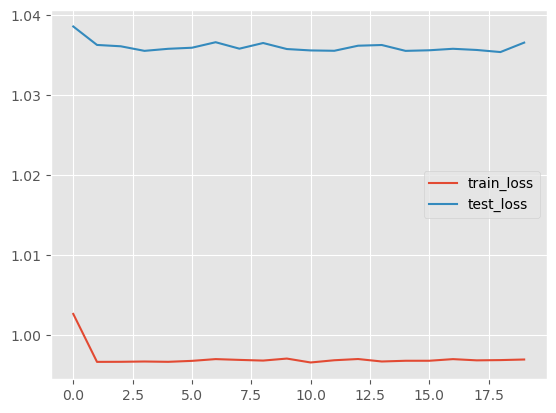

In [15]:
pd.concat([pd.Series(full_nn.train_loss).rename('train_loss'), pd.Series(full_nn.test_loss).rename('test_loss')], axis=1).plot();

In [16]:
comp = benchmark_comparison.Comparator(models=[full_nn], model_names=['nn'])

In [17]:
opt_dim = z.y_pred_optimal.shape
comp.correl(train, z)

,y_true,y_optimal,y_linear,y_seasonal,y_conditional,y_shift
y_optimal,0.0323,nan,nan,nan,nan,nan
y_linear,0.0185,0.6675,nan,nan,nan,nan
y_seasonal,0.0001,0.0976,-0.0024,nan,nan,nan
y_conditional,0.0272,0.7046,0.0069,0.0016,nan,nan
y_shift,0.0044,0.2331,-0.0033,0.0010,0.0018,nan
nn,0.0097,0.3059,0.2612,-0.0917,0.0682,0.4008


In [18]:
comp.correl(test, z)

,y_true,y_optimal,y_linear,y_seasonal,y_conditional,y_shift
y_optimal,0.0299,nan,nan,nan,nan,nan
y_linear,0.0185,0.6704,nan,nan,nan,nan
y_seasonal,0.0029,0.0905,-0.0101,nan,nan,nan
y_conditional,0.0208,0.6984,0.0031,-0.0053,nan,nan
y_shift,0.0112,0.2296,-0.0114,-0.0019,0.0029,nan
nn,0.0128,0.2997,0.2538,-0.0947,0.0662,0.3938


### Fully connected

In [19]:
train, test = utils.np_to_torch(X, y)

In [20]:
train.batch_size, test.batch_size

(64, 64)

In [21]:
from torch import nn
device = 'mps'

class NeuralNetwork(nn.Module):
    def __init__(self, n_ts, n_f):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n_ts*n_f, 512),
            nn.ReLU(),
            # nn.Linear(512, 512),
            # nn.ReLU(),
            nn.Linear(512, n_ts),
        )
        
        self.linear_relu_stack = nn.Sequential(nn.Linear(n_ts*n_f, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, n_ts)
                                              )

    def forward(self, x):
        x = self.flatten(x)
        pred = self.linear_relu_stack(x)
        return pred

In [22]:
m = NeuralNetwork(n_ts=100, n_f=10).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=1e-3, weight_decay=1e-2)


full_nn = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

In [23]:
full_nn.fit(train, test, epochs=20)

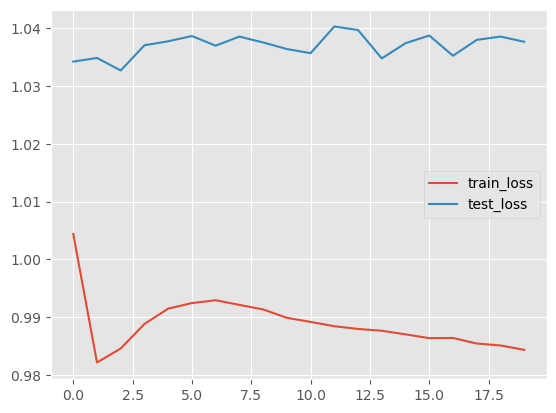

In [24]:
pd.concat([pd.Series(full_nn.train_loss).rename('train_loss'), pd.Series(full_nn.test_loss).rename('test_loss')], axis=1).plot();

In [25]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, full_nn], model_names=['lasso', 'lr', 'nn'])

In [27]:
comp.correl(train, z)

,y_true,y_optimal,y_linear,y_seasonal,y_conditional,y_shift,lasso,lr
y_optimal,0.0323,nan,nan,nan,nan,nan,nan,nan
y_linear,0.0185,0.6675,nan,nan,nan,nan,nan,nan
y_seasonal,0.0001,0.0976,-0.0024,nan,nan,nan,nan,nan
y_conditional,0.0272,0.7046,0.0069,0.0016,nan,nan,nan,nan
y_shift,0.0044,0.2331,-0.0033,0.0010,0.0018,nan,nan,nan
lasso,0.0187,0.6755,0.9992,-0.0023,0.0068,0.0331,nan,nan
lr,0.0198,0.6724,0.9348,-0.0372,0.0053,0.2215,0.9446,nan
nn,0.1351,0.0030,-0.0022,-0.0011,0.0061,0.0012,-0.0022,-0.0025


In [28]:
comp.correl(test, z)

,y_true,y_optimal,y_linear,y_seasonal,y_conditional,y_shift,lasso,lr
y_optimal,0.0299,nan,nan,nan,nan,nan,nan,nan
y_linear,0.0185,0.6704,nan,nan,nan,nan,nan,nan
y_seasonal,0.0029,0.0905,-0.0101,nan,nan,nan,nan,nan
y_conditional,0.0208,0.6984,0.0031,-0.0053,nan,nan,nan,nan
y_shift,0.0112,0.2296,-0.0114,-0.0019,0.0029,nan,nan,nan
lasso,0.0189,0.6784,0.9992,-0.0101,0.0030,0.0248,nan,nan
lr,0.0189,0.6756,0.9354,-0.0452,0.0019,0.2137,0.9450,nan
nn,0.0081,0.0046,0.0006,-0.0052,0.0085,-0.0048,0.0004,0.0010


### LSTM model with 10 timestamps

In [29]:
train, test = utils.np_to_torch(X, y, n_rolling=10)

In [30]:
from torch import nn
device = 'mps'

class LSTMModel(nn.Module):
    def __init__(self, n_ts, n_f, n_rolling, hidden_dim=128):
        super().__init__()
        self.encoder = nn.LSTM(input_size=n_ts*n_f, hidden_size=hidden_dim, batch_first=True)
        self.decoder = nn.Linear(hidden_dim, n_ts)
    
    def forward(self, x):
        # warning: lstm dimension needs to be flattened:
        # x: (batch, T=10, n_ts*n_f)
        _, (h, _) = self.encoder(x.reshape(x.shape[0], x.shape[1], x.shape[2] * x.shape[3]))
        out = self.decoder(h[-1]) 
        return out

In [31]:
m = LSTMModel(n_ts=100, n_f=10, n_rolling=10).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)


model_lstm = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

In [32]:
model_lstm.fit(train, test=test, epochs=10)

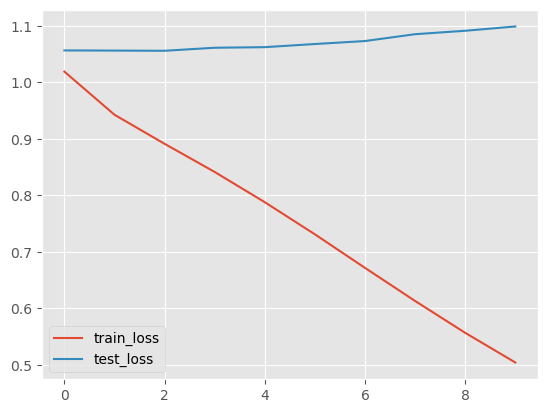

In [33]:
pd.concat([pd.Series(model_lstm.train_loss).rename('train_loss'), pd.Series(model_lstm.test_loss).rename('test_loss')], axis=1).plot();

In [34]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, model_lstm], model_names=['lasso', 'lr', 'lstm'])

In [35]:
comp.correl(train, z)

,y_true,y_optimal,y_linear,y_seasonal,y_conditional,y_shift,lasso,lr
y_optimal,0.0323,nan,nan,nan,nan,nan,nan,nan
y_linear,0.0185,0.6675,nan,nan,nan,nan,nan,nan
y_seasonal,0.0001,0.0976,-0.0024,nan,nan,nan,nan,nan
y_conditional,0.0272,0.7046,0.0069,0.0016,nan,nan,nan,nan
y_shift,0.0044,0.2331,-0.0033,0.0010,0.0018,nan,nan,nan
lasso,0.0187,0.6755,0.9992,-0.0023,0.0068,0.0331,nan,nan
lr,0.0198,0.6724,0.9348,-0.0372,0.0053,0.2215,0.9446,nan
lstm,0.7789,0.0278,0.0149,0.0011,0.0231,0.0071,0.0152,0.0167


In [36]:
comp.correl(test, z)

,y_true,y_optimal,y_linear,y_seasonal,y_conditional,y_shift,lasso,lr
y_optimal,0.0299,nan,nan,nan,nan,nan,nan,nan
y_linear,0.0185,0.6704,nan,nan,nan,nan,nan,nan
y_seasonal,0.0029,0.0905,-0.0101,nan,nan,nan,nan,nan
y_conditional,0.0208,0.6984,0.0031,-0.0053,nan,nan,nan,nan
y_shift,0.0112,0.2296,-0.0114,-0.0019,0.0029,nan,nan,nan
lasso,0.0189,0.6784,0.9992,-0.0101,0.0030,0.0248,nan,nan
lr,0.0189,0.6756,0.9354,-0.0452,0.0019,0.2137,0.9450,nan
lstm,0.0057,0.0048,0.0006,-0.0084,0.0080,-0.0013,0.0006,-0.0001


### Transformer

In [44]:
class TransformerEncoderModel(nn.Module):
    def __init__(self, n_ts, n_f, n_rolling, d_model=128, nhead=8, num_layers=2, dropout=0.5):
        super().__init__()
        self.input_dim = n_ts * n_f
        self.d_model = d_model

        # Linear projection of (n_ts*n_f) features
        self.input_proj = nn.Linear(self.input_dim, d_model)

        # Positional encoding (learned or sinusoidal)
        self.pos_embedding = nn.Parameter(torch.randn(1, n_rolling, d_model))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=4 * d_model,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # prediction
        self.decoder = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, n_ts)
        )

    def forward(self, x, mask=None):
        # x: (batch, n_rolling, n_ts, n_f)
        B, n_rolling, n_ts, n_f = x.shape

        # Flatten dimensions that are not lookback
        x = x.reshape(B, n_rolling, n_ts*n_f)
        x = self.input_proj(x) + self.pos_embedding[:, :n_rolling, :]

        # pass through Transformer encoder
        encoded = self.encoder(x, src_key_padding_mask=mask)  

        # last time step’s embedding for prediction
        out = self.decoder(encoded[:, -1, :])  # (B, N)
        return out

In [45]:
m = TransformerEncoderModel(100, 10, 10).to(device)
optimizer = torch.optim.Adam(m.parameters(), lr=0.001)


model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)

In [46]:
model_torch.fit(train, test=test, epochs=10)

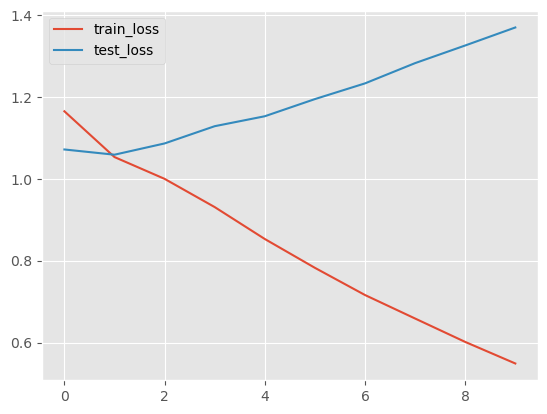

In [47]:
pd.concat([pd.Series(model_torch.train_loss).rename('train_loss'), pd.Series(model_torch.test_loss).rename('test_loss')], axis=1).plot();

In [48]:
comp = benchmark_comparison.Comparator(models=[lasso, lr, model_lstm, model_torch], model_names=['lasso', 'lr', 'lstm', 'transformer'])

In [49]:
comp.correl(train, z)

,y_true,y_optimal,y_linear,y_seasonal,y_conditional,y_shift,lasso,lr,lstm
y_optimal,0.0323,nan,nan,nan,nan,nan,nan,nan,nan
y_linear,0.0185,0.6675,nan,nan,nan,nan,nan,nan,nan
y_seasonal,0.0001,0.0976,-0.0024,nan,nan,nan,nan,nan,nan
y_conditional,0.0272,0.7046,0.0069,0.0016,nan,nan,nan,nan,nan
y_shift,0.0044,0.2331,-0.0033,0.0010,0.0018,nan,nan,nan,nan
lasso,0.0187,0.6755,0.9992,-0.0023,0.0068,0.0331,nan,nan,nan
lr,0.0198,0.6724,0.9348,-0.0372,0.0053,0.2215,0.9446,nan,nan
lstm,0.7789,0.0278,0.0149,0.0011,0.0231,0.0071,0.0152,0.0167,nan
transformer,0.7487,0.0272,0.0177,-0.0010,0.0214,0.0025,0.0178,0.0194,0.6649


In [50]:
comp.correl(test, z)

,y_true,y_optimal,y_linear,y_seasonal,y_conditional,y_shift,lasso,lr,lstm
y_optimal,0.0299,nan,nan,nan,nan,nan,nan,nan,nan
y_linear,0.0185,0.6704,nan,nan,nan,nan,nan,nan,nan
y_seasonal,0.0029,0.0905,-0.0101,nan,nan,nan,nan,nan,nan
y_conditional,0.0208,0.6984,0.0031,-0.0053,nan,nan,nan,nan,nan
y_shift,0.0112,0.2296,-0.0114,-0.0019,0.0029,nan,nan,nan,nan
lasso,0.0189,0.6784,0.9992,-0.0101,0.0030,0.0248,nan,nan,nan
lr,0.0189,0.6756,0.9354,-0.0452,0.0019,0.2137,0.9450,nan,nan
lstm,0.0057,0.0048,0.0006,-0.0084,0.0080,-0.0013,0.0006,-0.0001,nan
transformer,-0.0027,0.0039,0.0086,-0.0051,-0.0002,-0.0051,0.0084,0.0081,0.1980
